In [59]:
# Backtesting strategy: combining renko with obv indicator

import numpy as np
import pandas as pd
from stocktrends import Renko
import statsmodels.api as sm
from alpha_vantage.timeseries import TimeSeries
import time
import copy
import yfinance as yf

In [73]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def slope(ser,n):
    "function to calculate the slope of n consecutive points on a plot"
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y = ser[i-n:i]
        x = np.array(range(n))
        y_scaled = (y - y.min())/(y.max() - y.min())
        x_scaled = (x - x.min())/(x.max() - x.min())
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)

def renko_DF(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    df2.brick_size = max(0.5,round(ATR(DF,120)["ATR"][-1],0))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    
def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [36]:
# Download historical data for DJI constituent stocks
tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]

In [46]:
ohlc_intraday = {} # directory with ohlc value for each stock   

In [48]:
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker, period="60d", interval='5m')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [157]:
ohlc_intraday

{'MSFT':                                  Open        High         Low       Close  \
 Datetime                                                                    
 2021-02-11 09:30:00-05:00  244.779999  245.149994  243.869995  244.139999   
 2021-02-11 09:35:00-05:00  244.126205  244.889999  244.020096  244.320007   
 2021-02-11 09:40:00-05:00  244.179993  244.369995  243.805206  243.850006   
 2021-02-11 09:45:00-05:00  244.020004  244.179993  243.600006  243.630005   
 2021-02-11 09:50:00-05:00  243.589996  243.630005  242.869995  242.925003   
 ...                               ...         ...         ...         ...   
 2021-05-07 13:20:00-04:00  252.559998  252.559998  252.229996  252.470001   
 2021-05-07 13:25:00-04:00  252.429993  252.440002  252.220001  252.259995   
 2021-05-07 13:30:00-04:00  252.270004  252.668198  252.270004  252.660004   
 2021-05-07 13:35:00-04:00  252.669998  252.696503  252.399994  252.421799   
 2021-05-07 13:40:48-04:00  252.360001  252.360001  252.

In [158]:
ohlc_intraday["MSFT"]

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-02-11 09:30:00-05:00,244.779999,245.149994,243.869995,244.139999,244.139999,888609
2021-02-11 09:35:00-05:00,244.126205,244.889999,244.020096,244.320007,244.320007,299333
2021-02-11 09:40:00-05:00,244.179993,244.369995,243.805206,243.850006,243.850006,269583
2021-02-11 09:45:00-05:00,244.020004,244.179993,243.600006,243.630005,243.630005,220655
2021-02-11 09:50:00-05:00,243.589996,243.630005,242.869995,242.925003,242.925003,292361
...,...,...,...,...,...,...
2021-05-07 13:20:00-04:00,252.559998,252.559998,252.229996,252.470001,252.470001,155314
2021-05-07 13:25:00-04:00,252.429993,252.440002,252.220001,252.259995,252.259995,127982
2021-05-07 13:30:00-04:00,252.270004,252.668198,252.270004,252.660004,252.660004,135002


In [159]:
tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data
tickers

dict_keys(['MSFT', 'AAPL', 'FB', 'AMZN', 'INTC', 'CSCO', 'VZ', 'IBM', 'QCOM', 'LYFT'])

In [178]:
################################Backtesting####################################

#Merging renko df with original ohlc df
ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("merging for ",ticker)
    renko = renko_DF(df[ticker])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num"]
    df[ticker]["Date"] = df[ticker].index
    df[ticker]["Date"] = df[ticker]["Date"].astype(str)
    
    ohlc_renko[ticker] = df[ticker].merge(renko.loc[:,["Date","bar_num"]],how="outer",on="Date")
    ohlc_renko[ticker]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[ticker]["obv"]= OBV(ohlc_renko[ticker])
    ohlc_renko[ticker]["obv_slope"]= slope(ohlc_renko[ticker]["obv"],5)

merging for  MSFT


<ipython-input-73-7b2840bca34a>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
<ipython-input-73-7b2840bca34a>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
<ipython-input-73-7b2840bca34a>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['direction'][0] = 0


merging for  AAPL
merging for  FB
merging for  AMZN
merging for  INTC
merging for  CSCO
merging for  VZ
merging for  IBM
merging for  QCOM
merging for  LYFT


In [179]:
for ticker in tickers:
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

In [180]:
tickers_signal

{'MSFT': '',
 'AAPL': '',
 'FB': '',
 'AMZN': '',
 'INTC': '',
 'CSCO': '',
 'VZ': '',
 'IBM': '',
 'QCOM': '',
 'LYFT': ''}

In [181]:
tickers_ret

{'MSFT': [],
 'AAPL': [],
 'FB': [],
 'AMZN': [],
 'INTC': [],
 'CSCO': [],
 'VZ': [],
 'IBM': [],
 'QCOM': [],
 'LYFT': []}

In [182]:
ohlc_renko["FB"]

,Open,High,Low,Close,Adj Close,Volume,Date,bar_num,obv,obv_slope
0,271.890015,272.459991,270.820007,272.000000,272.000000,520265.0,2021-02-11 09:30:00-05:00,NaN,0.0,0.000000
1,271.869995,273.549896,271.799988,272.790009,272.790009,266673.0,2021-02-11 09:35:00-05:00,NaN,266673.0,0.000000
2,272.750000,272.750000,271.329987,271.704987,271.704987,180159.0,2021-02-11 09:40:00-05:00,NaN,86514.0,0.000000
3,271.915009,271.915009,271.089996,271.279999,271.279999,161560.0,2021-02-11 09:45:00-05:00,NaN,-75046.0,0.000000
4,271.250000,271.424988,270.685699,270.942688,270.942688,311746.0,2021-02-11 09:50:00-05:00,NaN,-386792.0,-34.321392
...,...,...,...,...,...,...,...,...,...,...
5115,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-06 13:00:00-04:00,4.0,NaN,NaN
5116,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-06 14:25:00-04:00,-1.0,NaN,NaN
5117,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-06 15:35:00-04:00,1.0,NaN,NaN
5118,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-06 15:55:00-04:00,2.0,NaN,NaN


In [183]:
#Identifying signals and calculating daily return
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    for i in range(len(ohlc_intraday[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"

        elif tickers_signal[ticker] == "Buy":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i]/ohlc_renko[ticker]["Adj Close"][i-1])-1)
            if ohlc_renko[ticker]["bar_num"][i]<=-2 and ohlc_renko[ticker]["obv_slope"][i]<-30:
                tickers_signal[ticker] = "Sell"
            elif ohlc_renko[ticker]["bar_num"][i]<2:
                tickers_signal[ticker] = ""
                
        elif tickers_signal[ticker] == "Sell":
            tickers_ret[ticker].append((ohlc_renko[ticker]["Adj Close"][i-1]/ohlc_renko[ticker]["Adj Close"][i])-1)
            if ohlc_renko[ticker]["bar_num"][i]>=2 and ohlc_renko[ticker]["obv_slope"][i]>30:
                tickers_signal[ticker] = "Buy"
            elif ohlc_renko[ticker]["bar_num"][i]>-2:
                tickers_signal[ticker] = ""

calculating daily returns for  MSFT
calculating daily returns for  AAPL
calculating daily returns for  FB
calculating daily returns for  AMZN
calculating daily returns for  INTC
calculating daily returns for  CSCO
calculating daily returns for  VZ
calculating daily returns for  IBM
calculating daily returns for  QCOM
calculating daily returns for  LYFT


In [192]:
len(tickers_ret[ticker])

4653

In [186]:
for ticker in tickers:
    print("calculating daily returns for ",ticker)
    ohlc_renko[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating daily returns for  MSFT


ValueError: Length of values does not match length of index

In [169]:
#calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_renko[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)
sharpe(strategy_df,0.025)
max_dd(strategy_df)  

<ipython-input-73-7b2840bca34a>:73: RuntimeWarning: divide by zero encountered in double_scalars
  sr = (CAGR(df) - rf)/volatility(df)


0.0

<AxesSubplot:>

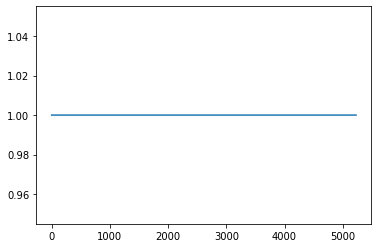

In [170]:
#visualizing strategy returns
(1+strategy_df["ret"]).cumprod().plot()

In [171]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_renko[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_renko[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_renko[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC
calculating KPIs for  CSCO
calculating KPIs for  VZ
calculating KPIs for  IBM
calculating KPIs for  QCOM
calculating KPIs for  LYFT


<ipython-input-73-7b2840bca34a>:73: RuntimeWarning: divide by zero encountered in double_scalars
  sr = (CAGR(df) - rf)/volatility(df)


,Return,Sharpe Ratio,Max Drawdown
MSFT,0.0,-inf,0.0
AAPL,0.0,-inf,0.0
FB,0.0,-inf,0.0
AMZN,0.0,-inf,0.0
INTC,0.0,-inf,0.0
CSCO,0.0,-inf,0.0
VZ,0.0,-inf,0.0
IBM,0.0,-inf,0.0
QCOM,0.0,-inf,0.0
LYFT,0.0,-inf,0.0
